In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append("../../Functions")
from GS_waves import select_freq_range, propagation_ew
from abtem.waves import PlaneWave
from Column_matching import (
    Bessel_transform,
    propagation_Bessel
)
import Generate_structure
from ase.visualize.plot import plot_atoms
from ase.io import read, write
from Complex_Gaussian import(
    Gaussian_function,
    Gaussian_in_focus,
    Gaussian_fitting
)
from Defocus_circle import generate_continious_phase
from sklearn.linear_model import LinearRegression
from ase.visualize.plot import plot_atoms
from tqdm import tqdm
from circle_fit import least_squares_circle

100%|██████████| 77/77 [00:49<00:00,  1.56it/s]


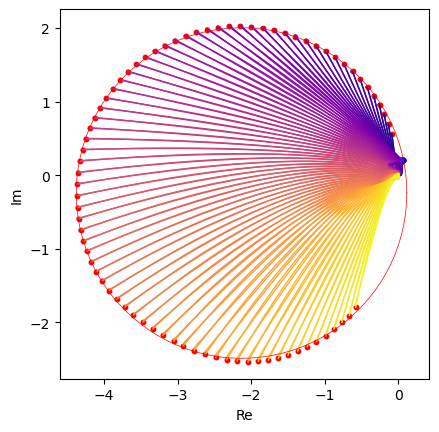

In [2]:
#Parameters to set
gmin = 0; gmax = 2; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
max_thickness = 80
thickness_range = np.arange(3, max_thickness, 1)
cmap = plt.get_cmap("plasma")
coeff_rec = []
theta = np.linspace(0, 2*np.pi, 100)
peak_rec = []
lines = []
for thickness in tqdm(thickness_range):
#    structure_1 = Generate_structure.generate_column("Al", thickness, a, a)
    n_repeat = 3
    structure_1 = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    exitwave_1 = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_1).array),
                            gmin, gmax, sampling)
    m, n = exitwave_1.shape
    exitwave_1 = exitwave_1[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave_1.shape
    index = np.unravel_index(np.argmax(np.abs(exitwave_1)), exitwave_1.shape)
    peak_rec.append(exitwave_1[index])
    results, components = Bessel_transform(exitwave_1-1, sampling, gmin+0.01, gmax, length, x0=sampling/2, y0=sampling/2)
    krange = np.linspace(gmin+0.01, gmax, length)
    index_sel = np.where(np.logical_and(krange>=0.2,
                                        krange<=0.8))
    fitted = Gaussian_fitting(results, krange, [0.01, 1], defocus=True)
    coeff = np.array(list(fitted.best_values.values()))
    bg = coeff[-2] + 1j*coeff[-1]
    coeff_rec.append(coeff)
    #Fit line for the complex component
    #a_re, a_im, b_re, b_im, c_re, c_im = coeff
    recover = Gaussian_function(krange, *coeff)
    #recover = Gaussian_in_focus(krange, *coeff)
    #plt.plot(np.real(recover-bg), np.imag(recover-bg), linewidth=1, color=cmap(thickness/max_thickness))
    line=plt.plot(np.real(recover), np.imag(recover), linewidth=1, color=cmap(thickness/max_thickness))
    lines.append(line)
    plt.plot(np.real(results), np.imag(results), linewidth=1, color=cmap(thickness/max_thickness))
    #plt.plot(krange, np.abs(results), color=cmap(thickness/max_thickness))
    #plt.plot(krange**2, np.log(np.abs(results)), color=cmap(thickness/max_thickness))
coeff_rec = np.array(coeff_rec)
peak_rec = np.array(peak_rec)
#plt.xlim([0, 0.5])
coeff_complex = coeff_rec[:,0] + 1j*coeff_rec[:,1]
coeff_bg = coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
coeff_total = coeff_complex + coeff_bg
#plt.scatter(np.real(coeff_total), np.imag(coeff_total), color='r', s=10)
s=plt.scatter(np.real(coeff_total), np.imag(coeff_total), 
              c=thickness_range, cmap="plasma", s=5)
plt.scatter(np.real(coeff_total), np.imag(coeff_total), color='r', s=10)
plt.scatter(np.real(coeff_bg), np.imag(coeff_bg), color='b', s=10)
coordinates_to_fit = np.vstack((np.real(coeff_total), np.imag(coeff_total))).T
xc, yc, r, sigma = least_squares_circle(coordinates_to_fit)
plt.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), color='r', linewidth=0.5)
#plt.colorbar(s)
#plt.plot(np.real(peak_rec-1), np.imag(peak_rec-1), color='g', linewidth=0.5)
plt.axis("square")
plt.xlabel("Re")
plt.ylabel("Im")
plt.show()
#plt.plot(thickness_range, coeff_rec)
#plt.show()

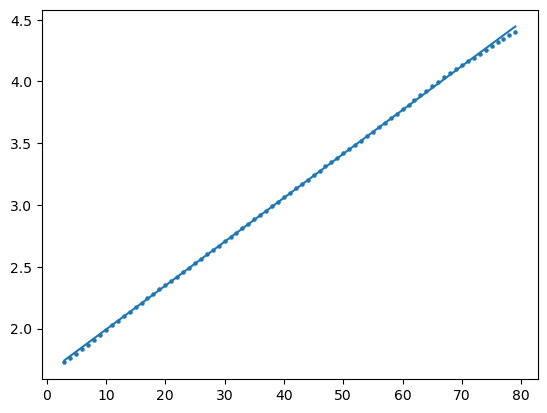

In [3]:
coeff_complex = coeff_rec[:,0] + 1j*coeff_rec[:,1]
coeff_bg = coeff_rec[:,-2] + 1j*coeff_rec[:,-1]
coeff_total = coeff_complex + coeff_bg
plt.scatter(thickness_range, generate_continious_phase(coeff_total), s=5)
res = LinearRegression().fit(thickness_range.reshape(-1, 1), generate_continious_phase(coeff_total))
plt.plot(thickness_range, res.predict(thickness_range.reshape(-1, 1)))
plt.show()

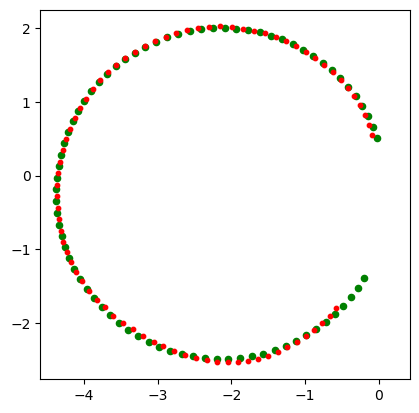

In [15]:
slope = res.coef_[0]; bias = res.intercept_
phase_column = slope * thickness_range + bias - np.pi/2
x_pred = xc + r*np.cos(2*phase_column)
y_pred = yc + r*np.sin(2*phase_column)
plt.scatter(x_pred, y_pred, color='g', s=20)
plt.scatter(np.real(coeff_total), np.imag(coeff_total), color='r', s=10)
plt.axis("square")
plt.show()

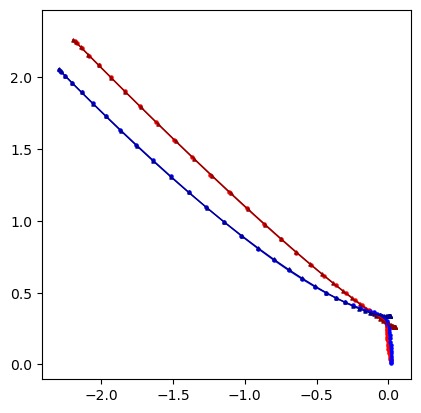

In [29]:
#Parameters to set
gmin = 0; gmax = 1.5; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 1
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
coeff_rec = []
coeff_res_rec = []
#Generate isolated structure
dopant_index = 10
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                        gmin, gmax, sampling)
exitwave_all = exitwave_all - 1
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                    x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
fitted = Gaussian_fitting(results, krange, [0.01, 1])
coeff = np.array(list(fitted.best_values.values()))
coeff1 = coeff
bg = coeff[-2] + 1j*coeff[-1]
recovered = Gaussian_function(krange, *coeff)
residue1 = results - recovered + bg
plt.plot(np.real(results), np.imag(results), color='r', linewidth=1)
plt.scatter(np.real(results), np.imag(results), color='r', s=5)
plt.plot(np.real(recovered), np.imag(recovered), color='darkred', linewidth=1)
plt.scatter(np.real(recovered), np.imag(recovered), marker="^", color='darkred', s=5)
structure_doped = Generate_structure.set_dopants_fcc(structure, a, dopant_index, 13, 47)
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_doped).array),
                        gmin, gmax, sampling)
exitwave_all = exitwave_all - 1
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                    x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
fitted = Gaussian_fitting(results, krange, [0.01, 1])
coeff = np.array(list(fitted.best_values.values()))
coeff2 = coeff
bg = coeff[-2] + 1j*coeff[-1]
recovered = Gaussian_function(krange, *coeff)
residue2 = results - recovered + bg
plt.plot(np.real(results), np.imag(results), color='b', linewidth=1)
plt.scatter(np.real(results), np.imag(results), color='b', s=5)
plt.plot(np.real(recovered), np.imag(recovered), color='darkblue', linewidth=1)
plt.scatter(np.real(recovered), np.imag(recovered), marker="^", color='darkblue', s=5)
plt.axis("square")
plt.show()

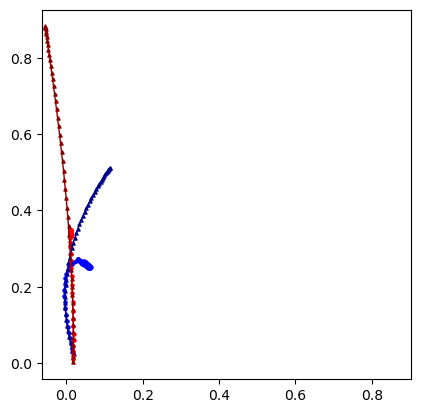

In [36]:
fitted = Gaussian_fitting(residue1, krange, [1, gmax])
coeff_rec = np.array(list(fitted.best_values.values()))
res_rec1 = Gaussian_function(krange, *coeff_rec)
bg_rec1 = coeff_rec[-2] + 1j*coeff_rec[-1]
fitted = Gaussian_fitting(residue2, krange, [1, gmax])
coeff_rec = np.array(list(fitted.best_values.values()))
res_rec2 = Gaussian_function(krange, *coeff_rec)
bg_rec2 = coeff_rec[-2] + 1j*coeff_rec[-1]
plt.plot(np.real(residue1), np.imag(residue1), color='b', linewidth=1)
plt.scatter(np.real(residue1), np.imag(residue1), color='b', s=5)
plt.plot(np.real(res_rec1), np.imag(res_rec1), color='darkblue', linewidth=1)
plt.scatter(np.real(res_rec1), np.imag(res_rec1), marker="^", color='darkblue', s=5)
plt.plot(np.real(residue2), np.imag(residue2), color='r', linewidth=1)
plt.scatter(np.real(residue2), np.imag(residue2), color='r', s=5)
plt.plot(np.real(res_rec2), np.imag(res_rec2), color='darkred', linewidth=1)
plt.scatter(np.real(res_rec2), np.imag(res_rec2), marker="^", color='darkred', s=5)
plt.axis("square")
plt.show()

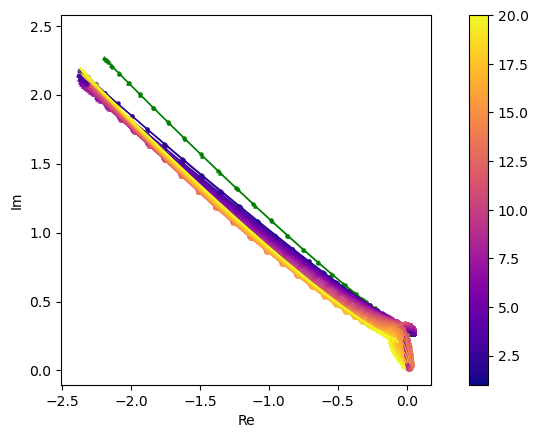

In [75]:
#Parameters to set
gmin = 0; gmax = 1.5; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 1
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
coeff_rec = []
coeff_res_rec = []
dopant_index_range = np.arange(1, 21, 1)
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                        gmin, gmax, sampling)
exitwave_all = exitwave_all - 1
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                    x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
fitted = Gaussian_fitting(results, krange, [0.01, 1])
coeff = np.array(list(fitted.best_values.values()))
coeff1 = coeff
bg = coeff[-2] + 1j*coeff[-1]
recovered = Gaussian_function(krange, *coeff)
residue1 = results - recovered + bg
plt.plot(np.real(results), np.imag(results), color='g', linewidth=1)
plt.scatter(np.real(results), np.imag(results), color='g', s=5)
plt.plot(np.real(recovered), np.imag(recovered), color='g', linewidth=1)
plt.scatter(np.real(recovered), np.imag(recovered), marker="^", color='g', s=5)
#Generate isolated structure
for dopant_index in dopant_index_range:
    structure_doped = Generate_structure.set_dopants_fcc(structure, a, dopant_index, 13, 47)
    exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_doped).array),
                            gmin, gmax, sampling)
    exitwave_all = exitwave_all - 1
    m, n = exitwave_all.shape
    exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave.shape
    x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
    results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                        x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    coeff2 = coeff
    coeff_rec.append(coeff)
    bg = coeff[-2] + 1j*coeff[-1]
    recovered = Gaussian_function(krange, *coeff)
    residue2 = results - recovered + bg
    plt.plot(np.real(results), np.imag(results), color=cmap(dopant_index/20), linewidth=1)
    plt.scatter(np.real(results), np.imag(results), color=cmap(dopant_index/20), s=5)
    plt.plot(np.real(recovered), np.imag(recovered), color=cmap(dopant_index/20), linewidth=1)
    plt.scatter(np.real(recovered), np.imag(recovered), marker="^", color=cmap(dopant_index/20), s=5)
coeff_rec = np.array(coeff_rec)
s = plt.scatter(coeff_rec[:,-2], coeff_rec[:,-1], c=dopant_index_range, cmap="plasma", s=0.01)
plt.colorbar(s)
plt.xlabel("Re")
plt.ylabel("Im")
plt.axis("square")
plt.show()

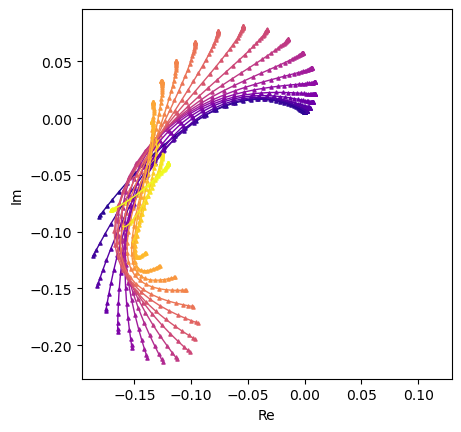

In [76]:
#Parameters to set
gmin = 0; gmax = 1.5; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 1
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
coeff_rec = []
coeff_res_rec = []
dopant_index_range = np.arange(1, 21, 1)
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                        gmin, gmax, sampling)
exitwave_all = exitwave_all - 1
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                    x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
fitted = Gaussian_fitting(results, krange, [0.01, 1])
coeff = np.array(list(fitted.best_values.values()))
coeff1 = coeff
bg = coeff[-2] + 1j*coeff[-1]
recovered = Gaussian_function(krange, *coeff)
residue1 = results - recovered + bg
results_prime = results
recovered_prime = recovered
#Generate isolated structure
for dopant_index in dopant_index_range:
    structure_doped = Generate_structure.set_dopants_fcc(structure, a, dopant_index, 13, 47)
    exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_doped).array),
                            gmin, gmax, sampling)
    exitwave_all = exitwave_all - 1
    m, n = exitwave_all.shape
    exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave.shape
    x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
    results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                        x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    coeff2 = coeff
    bg = coeff[-2] + 1j*coeff[-1]
    recovered = Gaussian_function(krange, *coeff)
    residue2 = results - recovered + bg
    #plt.plot(np.real(results-results_prime), np.imag(results-results_prime), color=cmap(dopant_index/20), linewidth=1)
    #plt.scatter(np.real(results-results_prime), np.imag(results-results_prime), color=cmap(dopant_index/20), s=5)
    plt.plot(np.real(recovered-recovered_prime), np.imag(recovered-recovered_prime), color=cmap(dopant_index/20), linewidth=1)
    plt.scatter(np.real(recovered-recovered_prime), np.imag(recovered-recovered_prime), marker="^", color=cmap(dopant_index/20), s=5)
    #plt.plot(krange**2, generate_continious_phase(recovered-recovered_prime), color=cmap(dopant_index/20), linewidth=1)
plt.xlabel("Re")
plt.ylabel("Im")
plt.axis("square")
plt.show()

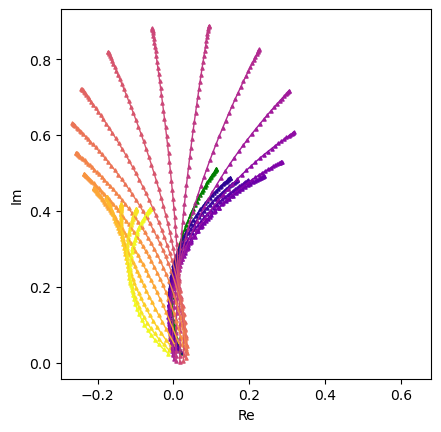

In [77]:
#Parameters to set
gmin = 0; gmax = 1.5; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 1
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
coeff_rec = []
coeff_res_rec = []
dopant_index_range = np.arange(1, 21, 1)
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                        gmin, gmax, sampling)
exitwave_all = exitwave_all - 1
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                    x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
fitted = Gaussian_fitting(results, krange, [0.01, 1])
coeff = np.array(list(fitted.best_values.values()))
coeff1 = coeff
bg = coeff[-2] + 1j*coeff[-1]
recovered = Gaussian_function(krange, *coeff)
residue1 = results - recovered + bg
fitted = Gaussian_fitting(residue1, krange, [1, gmax])
coeff_rec = np.array(list(fitted.best_values.values()))
res_rec1 = Gaussian_function(krange, *coeff_rec)
bg_rec1 = coeff_rec[-2] + 1j*coeff_rec[-1]
#plt.plot(np.real(residue1), np.imag(residue1), color='g', linewidth=1)
#plt.scatter(np.real(residue1), np.imag(residue1), color='g', s=5)
plt.plot(np.real(res_rec1), np.imag(res_rec1), color='g', linewidth=1)
plt.scatter(np.real(res_rec1), np.imag(res_rec1), marker="^", color='g', s=5)
#Generate isolated structure
for dopant_index in dopant_index_range:
    structure_doped = Generate_structure.set_dopants_fcc(structure, a, dopant_index, 13, 47)
    exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_doped).array),
                            gmin, gmax, sampling)
    exitwave_all = exitwave_all - 1
    m, n = exitwave_all.shape
    exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave.shape
    x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
    results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                        x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    coeff2 = coeff
    bg = coeff[-2] + 1j*coeff[-1]
    recovered = Gaussian_function(krange, *coeff)
    residue2 = results - recovered + bg
    fitted = Gaussian_fitting(residue2, krange, [1, gmax])
    coeff_rec = np.array(list(fitted.best_values.values()))
    res_rec2 = Gaussian_function(krange, *coeff_rec)
    bg_rec2 = coeff_rec[-2] + 1j*coeff_rec[-1]
    #plt.plot(np.real(residue2), np.imag(residue2), color=cmap(dopant_index/20), linewidth=1)
    #plt.scatter(np.real(residue2), np.imag(residue2), color=cmap(dopant_index/20), s=5)
    plt.plot(np.real(res_rec2), np.imag(res_rec2), color=cmap(dopant_index/20), linewidth=1)
    plt.scatter(np.real(res_rec2), np.imag(res_rec2), marker="^", color=cmap(dopant_index/20), s=5)
plt.xlabel("Re")
plt.ylabel("Im")
plt.axis("square")
plt.show()

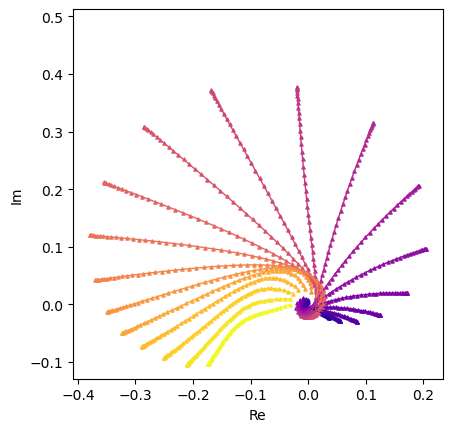

In [78]:
#Parameters to set
gmin = 0; gmax = 1.5; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 1
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
coeff_rec = []
coeff_res_rec = []
dopant_index_range = np.arange(1, 21, 1)
structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure).array),
                        gmin, gmax, sampling)
exitwave_all = exitwave_all - 1
m, n = exitwave_all.shape
exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                        (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
m, n = exitwave.shape
x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                    x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
fitted = Gaussian_fitting(results, krange, [0.01, 1])
coeff = np.array(list(fitted.best_values.values()))
coeff1 = coeff
bg = coeff[-2] + 1j*coeff[-1]
recovered = Gaussian_function(krange, *coeff)
residue1 = results - recovered + bg
fitted = Gaussian_fitting(residue1, krange, [1, gmax])
coeff_rec = np.array(list(fitted.best_values.values()))
res_rec1 = Gaussian_function(krange, *coeff_rec)
bg_rec1 = coeff_rec[-2] + 1j*coeff_rec[-1]
coeff_sub_rec = []
#Generate isolated structure
for dopant_index in dopant_index_range:
    structure_doped = Generate_structure.set_dopants_fcc(structure, a, dopant_index, 13, 47)
    exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_doped).array),
                            gmin, gmax, sampling)
    exitwave_all = exitwave_all - 1
    m, n = exitwave_all.shape
    exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave.shape
    x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
    results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                        x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    coeff2 = coeff
    bg = coeff[-2] + 1j*coeff[-1]
    recovered = Gaussian_function(krange, *coeff)
    residue2 = results - recovered + bg
    fitted = Gaussian_fitting(residue2, krange, [1, gmax])
    coeff_rec = np.array(list(fitted.best_values.values()))
    res_rec2 = Gaussian_function(krange, *coeff_rec)
    bg_rec2 = coeff_rec[-2] + 1j*coeff_rec[-1]
    res_rec_sub = res_rec2-res_rec1
    fit_sub = Gaussian_fitting(res_rec_sub, krange, [1, gmax])
    coeff_sub = np.array(list(fit_sub.best_values.values()))
    coeff_sub_rec.append(coeff_sub)
    #plt.plot(np.real(residue2), np.imag(residue2), color=cmap(dopant_index/20), linewidth=1)
    #plt.scatter(np.real(residue2), np.imag(residue2), color=cmap(dopant_index/20), s=5)
    plt.plot(np.real(res_rec2-res_rec1), np.imag(res_rec2-res_rec1), color=cmap(dopant_index/20), linewidth=1)
    plt.scatter(np.real(res_rec2-res_rec1), np.imag(res_rec2-res_rec1), marker="^", color=cmap(dopant_index/20), s=5)
    #plt.plot(krange**2, generate_continious_phase(res_rec2-res_rec1), color=cmap(dopant_index/20), linewidth=1)
    #plt.scatter(krange**2, generate_continious_phase(res_rec2-res_rec1), marker="^", color=cmap(dopant_index/20), s=5)
coeff_sub_rec = np.array(coeff_sub_rec)
plt.xlabel("Re")
plt.ylabel("Im")
plt.axis("square")
plt.show()

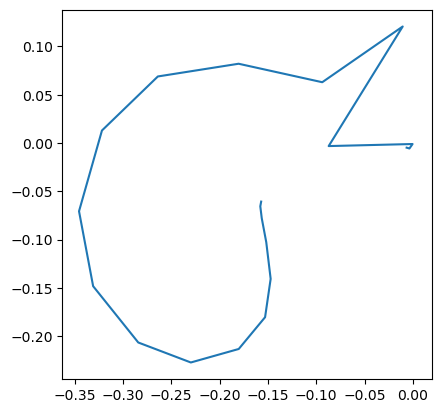

In [79]:
plt.plot(coeff_sub_rec[:,0]+coeff_sub_rec[:,-2], coeff_sub_rec[:,1]+coeff_sub_rec[:,-1])
plt.axis("square")
plt.show()

In [27]:
coeff1

array([-2.24097833,  2.0041298 ,  5.05938424, -0.31922918,  0.04407285,
        0.2609802 ])

In [28]:
coeff2

array([-2.30890901,  1.72001352,  4.72280794, -0.76170626,  0.01083393,
        0.33918172])

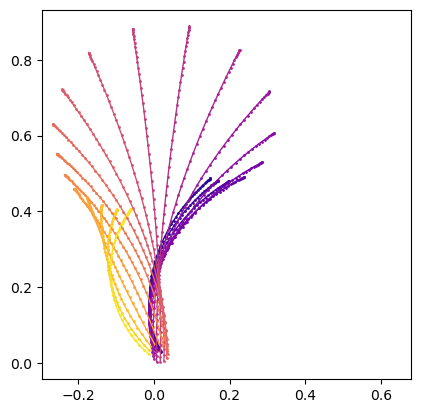

In [45]:
#Parameters to set
gmin = 0; gmax = 1.5; sampling = 0.0656015; energy = 300e3
a = 4.05; length = 50
#Results from isolated column
n_repeat = 1
thickness = 20
theta = np.linspace(0, 2*np.pi, 100)
cmap = plt.get_cmap("plasma")
cut_factor = 0.01
krange = np.linspace(gmin+cut_factor, gmax, length)
coeff_rec = []
coeff_res_rec = []
#Generate isolated structure
for dopant_index in range(1, 21):
    structure = Generate_structure.generate_periodic_fcc("Al", a, n_repeat, n_repeat, thickness)
    structure_doped = Generate_structure.set_dopants_fcc(structure, a, dopant_index, 13, 47)
    exitwave_all = select_freq_range(np.array(PlaneWave(sampling=sampling, energy=energy).multislice(structure_doped).array),
                            gmin, gmax, sampling)
    exitwave_all = exitwave_all - 1
    m, n = exitwave_all.shape
    exitwave = exitwave_all[(n_repeat*2-1)*m//(n_repeat*4):(n_repeat*2+1)*m//(n_repeat*4),
                            (n_repeat*2-1)*n//(n_repeat*4):(n_repeat*2+1)*n//(n_repeat*4)]
    m, n = exitwave.shape
    x0, y0 = np.unravel_index(np.argmax(np.abs(exitwave)), exitwave.shape)
    results, components = Bessel_transform(exitwave, sampling, gmin+cut_factor, gmax, length, 
                                        x0=(x0-(m-1)/2)*sampling, y0=(y0-(n-1)/2)*sampling)
    fitted = Gaussian_fitting(results, krange, [0.01, 1])
    coeff = np.array(list(fitted.best_values.values()))
    bg = coeff[-2] + 1j*coeff[-1]
    recovered = Gaussian_function(krange, *coeff)
    residue = results - recovered + bg
    fit_residue = Gaussian_fitting(residue, krange, [1, gmax])
    coeff_res = np.array(list(fit_residue.best_values.values()))
    coeff_res_rec.append(coeff_res)
    bg_res = coeff_res[-2] + 1j*coeff_res[-1]
    res_rec = Gaussian_function(krange, *coeff_res)
    plt.plot(np.real(res_rec), np.imag(res_rec), color=cmap(dopant_index/21), linewidth=1)
    plt.scatter(np.real(res_rec), np.imag(res_rec), color=cmap(dopant_index/21), s=1)
    index_sel = np.where(krange>1)
    #plt.plot(krange**2, generate_continious_phase(res_rec), color=cmap(dopant_index/21), linewidth=1)
    #plt.scatter(krange**2, generate_continious_phase(res_rec), color=cmap(dopant_index/21), s=1)
coeff_res_rec = np.array(coeff_res_rec)
plt.axis("square")
plt.show()

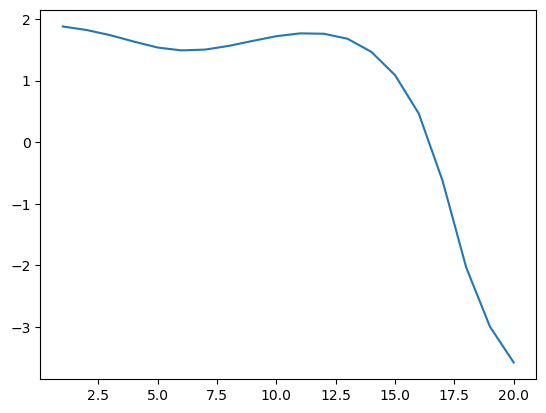

In [37]:
res_complex = coeff_res_rec[:,0] + 1j*coeff_res_rec[:,1]
plt.plot(range(1, 21), generate_continious_phase(res_complex))
plt.show()

In [ ]:
plt.plot(range(1, 21), generate_continious_phase(res_complex))
plt.show()